In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import tensorflow as tf

import vgg16
import utils
import os
import csv
from itertools import islice
import matplotlib.pyplot as plt

In [2]:
def get_lung_dataset_batch(images_directory, labels_file, lung_count, batch_num):
    if not hasattr(get_lung_dataset_batch, 'labels_by_name'):
        # read labels from csv
        get_lung_dataset_batch.labels_by_name = {}
        with open(labels_file, 'rb') as csv_labels:
            labels_reader = csv.reader(csv_labels)
            for row in islice(labels_reader, 1, None):
                get_lung_dataset_batch.labels_by_name[row[0]] = int(row[1])
            
    train_images = []
    train_labels = []
    #test_images = []
    #for _, _, files in os.walk(lungs_dir):
    #for f in files[batch_num*lung_count:(batch_num+1)*lung_count]:
    for lung_id in get_lung_dataset_batch.labels_by_name.keys()[batch_num*lung_count:(batch_num+1)*lung_count]:
        f = lung_id + '.npy'
        lung_img = np.load(lungs_dir + '/' + f)
        for ct_slice in lung_img:
            data_point = np.repeat([ct_slice], 3, axis=0)\
                .transpose(1, 2, 0)[1:-2,1:-2,:]
            #lung_id = f.split('.')[0]
            #if lung_id in labels_by_name:
            train_images.append(data_point)
            train_labels.append(get_lung_dataset_batch.labels_by_name[lung_id])
            #else:
                #test_images.append(data_point)

    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    #test_images = np.array(test_images)
    return {
        'X_train': train_images,
        'y_train': train_labels#,
        #'X_test': test_images
    }

In [3]:
# try getting a batch of the lung data

lungs_dir = '../input/3Darrays_stage1_2'
labels_file = '../input/stage1_labels.csv'

data = get_lung_dataset_batch(lungs_dir, labels_file, 5, 0)

print "Training data shape: {}".format(data['X_train'].shape)
print "Training labels shape: {}".format(data['y_train'].shape)
#print "Test data shape: {}".format(data['X_test'].shape)

Training data shape: (300, 224, 224, 3)
Training labels shape: (300,)


In [ ]:
ls -l ../input

In [ ]:
# extract vgg features from the image data

batch_size = 1
weights_file = './vgg16.npy'

train_size = 1397
num_batches = train_size / batch_size


def minibatch(batch):
    for item in batch['X_train']:
        yield item[None,:,:,:]


In [ ]:


gpu_feats = None
cpu_feats = None
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [60, 224, 224, 3])

        vgg = vgg16.Vgg16(weights_file)
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        for batch_num in xrange(1):#num_batches):
            batch_data = get_lung_dataset_batch(lungs_dir, labels_file, batch_size, batch_num)
            #batch_features = np.concatenate([sess.run(vgg.pool5, feed_dict={images: i}) for i in minibatch(batch_data)])
            feed_dict = {images: batch_data['X_train']}
            batch_features = sess.run(vgg.pool5, feed_dict=feed_dict)
            cpu_feats = batch_features
            print batch_features.shape

with tf.device('/gpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [1, 224, 224, 3])

        vgg = vgg16.Vgg16(weights_file)
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        for batch_num in xrange(1):#num_batches):
            batch_data = get_lung_dataset_batch(lungs_dir, labels_file, batch_size, batch_num)
            batch_features = np.concatenate([sess.run(vgg.pool5, feed_dict={images: i}) for i in minibatch(batch_data)])
            #feed_dict = {images: batch_data['X_train']}
            #batch_features = sess.run(vgg.pool5, feed_dict=feed_dict)
            gpu_feats = batch_features
            print batch_features.shape
            
print np.sum(np.square(gpu_feats - cpu_feats))

In [ ]:
print np.abs(gpu_feats).mean()
print np.abs(cpu_feats).mean()
print np.abs(cpu_feats - gpu_feats).mean()

print np.argmax(np.abs(gpu_feats - cpu_feats))
print np.max(np.abs(gpu_feats - cpu_feats))
print gpu_feats.reshape(60*7*7*512)[295322]
print cpu_feats.reshape(60*7*7*512)[295322]

In [ ]:
DEBUG = None
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [60, 224, 224, 3])

        vgg = vgg16.Vgg16(weights_file)
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        for batch_num in xrange(1):#num_batches):
            batch_data = get_lung_dataset_batch(lungs_dir, labels_file, batch_size, batch_num)
            #batch_features = np.concatenate([sess.run(vgg.pool5, feed_dict={images: i}) for i in minibatch(batch_data)])
            feed_dict = {images: batch_data['X_train']}
            DEBUG = sess.run(vgg.DEBUG, feed_dict=feed_dict)
print DEBUG.shape

In [ ]:
print DEBUG.mean()

In [ ]:
DEBUG = None
with tf.device('/cpu:0'):
    with tf.Session() as sess:
        images = tf.placeholder("float", [60, 224, 224, 3])

        vgg = vgg16.Vgg16(weights_file)
        with tf.name_scope("content_vgg"):
            vgg.build(images)

        for batch_num in xrange(1):#num_batches):
            batch_data = get_lung_dataset_batch(lungs_dir, labels_file, batch_size, batch_num)
            #batch_features = np.concatenate([sess.run(vgg.pool5, feed_dict={images: i}) for i in minibatch(batch_data)])
            feed_dict = {images: batch_data['X_train']}
            DEBUG = sess.run(vgg.DEBUG, feed_dict=feed_dict)
print DEBUG.shape

In [ ]:
print data['X_train'].max()
print data['X_train'].min()

plt.hist(data['X_train'].flatten(), bins=80, color='c')
plt.xlabel("pixel value")
plt.ylabel("frequency")

plt.show()

In [ ]:
img = data['X_train'][30,:,:,0]
print img.shape
zero_center = img > -600
notzero_center = img < -600
plt.imshow(zero_center, cmap=plt.cm.gray)
plt.show()
plt.imshow(notzero_center, cmap=plt.cm.gray)
plt.show()
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [ ]:
print img[25,25]

In [ ]:
def image_mask(img, low, high):
    return (img <= high) * (img >= low)
def show_img(img):
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()
def show_img_t(img, low, high):
    mask = image_mask(img, low, high)
    plt.imshow(img*mask, cmap=plt.cm.gray)
    plt.show()

In [ ]:
show_img_t(img, -20000, -9000)

In [ ]:
for band in xrange(-1500, 1500, 150):
    print "{} - {}".format(band, band + 150)
    show_img(image_mask(img, band, band + 150))
    show_img_t(img, band, band + 150)

In [ ]:
mask_high = (img > -200) * (img < -5)
mask_low = img < -375

img_high = img * mask_high
img_low = img * mask_low

show_img(img_high)
show_img(img_low)
show_img(img)

show_img(img_low + (img_high - mask_high * 300))
show_img(img_low - (mask_high * -300)*img)

In [ ]:
plt.hist(img.flatten(), bins=80)
plt.show()

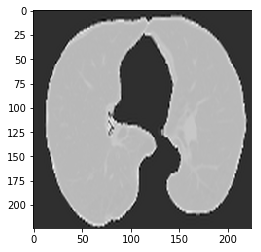

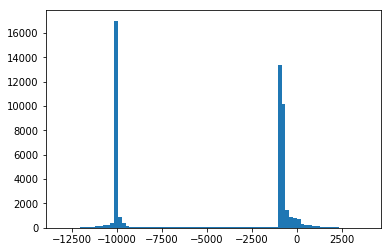

In [4]:
img = data['X_train'][30,:,:,0]
plt.imshow(img, cmap=plt.cm.gray)
plt.show()
plt.hist(img.flatten(), bins=80)
plt.show()


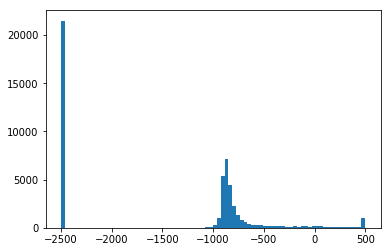

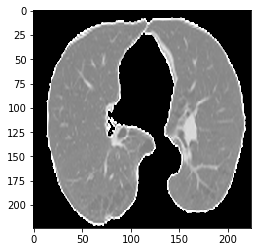

In [8]:
img2 = data['X_train'][30,:,:,0]
img2[img2 < -1500] = -2500
img2[img2 > 500] = 500
plt.hist(img2.flatten(), bins=80)
plt.show()
plt.imshow(img2, cmap=plt.cm.gray)
plt.show()